In [6]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from math import ceil, sqrt, prod
from scipy.stats import norm
from scipy import stats
from scipy.integrate import quad
import time
import math
import os

# Direct Random Weighted Graphs


In [7]:
# Setting the seed
np.random.seed(2060685 + 2139662 + 2139221)

### Random Weight
This class is responsible to manage the edge behaviour

In [8]:
class RandomWeight:
    def __init__(self, mean, standard_deviation):
        self.mean = mean
        self.standard_deviation = standard_deviation
        self.variance = standard_deviation**2

    def __str__(self):
        return f"N({round(self.mean, 10)}, {round(self.variance, 10)})"

    def sample(self):
        return np.random.normal(loc = self.mean, scale = self.standard_deviation)
    
    def cdf(self, x):
        return norm.cdf(x, loc = self.mean, scale = self.standard_deviation)

    def pdf(self, x):
        return norm.pdf(x, loc = self.mean, scale = self.standard_deviation)
    
    # IP rw1 first random weight
    # IP rw2 second random weight
    # OR the probability that rw1 <= rw2 assuming independence
    def prob_less(self, rw1, rw2):
        return norm.cdf(0, loc = rw1.mean - rw2.mean, scale = sqrt(rw1.variance + rw2.variance))
    
    # IP rw random weight
    # OR the probability that self <= rw assuming independence
    def prob_less_than(self, rw):
        return self.prob_less(self, rw)

In [10]:
# Returns a * x1 + b * x2
def linear_combination(a : float, x1 : RandomWeight, b : float, x2 : RandomWeight):
    return RandomWeight(a * x1.mean + b * x2.mean, sqrt(a**2 * x1.variance + b**2 * x2.variance))

In [9]:
class PathEstimate:
    def __init__(self, s, t, estimate : RandomWeight = None, isDiscovered : bool = False):
        self._s = s
        self._t = t
        self._estimate : RandomWeight = estimate
        self._isDiscovered = isDiscovered
    
    def set_estimate(self, estimate : RandomWeight):
        self._estimate = estimate
        self._isDiscovered = True
        return self

    def __str__(self):
        return f"({self._s}, {self._t}) -> estimate: {self._estimate}, isDiscovered: {self._isDiscovered}"

In [6]:
@DeprecationWarning
def prob_min_j(xis, j):
    prod([linear_combination(1, xis[j], -1, xis[i]).cdf(0) for i in range(len(xis)) if i != j])

### DRWG
This class will represent our model

In [11]:
class DRWG:
    # Default values
    _N = 10
    _P = .3
    _MEAN_INTERVAL = (1, 100)
    _STD_INTERVAL = (sqrt(0.1), sqrt(0.4))
    _SEED = 2060685 + 2139662 + 2139221
    _TITLE = "Graph"
    _FIGSIZE = (10, 10)
    _WITH_LABELS = True
    _NODE_COLOR = "lightblue"
    _EDGE_COLOR = "gray"
    _NODE_SIZE = 500
    _FONT_SIZE = 10
    _ARROWSIZE = 20
    _FONT_COLOR = "red"
    _SHORTEST_PATH_NODE_COLOR = "orange"
    _SHORTEST_PATH_EDGE_COLOR = "red" 

    def __init__(self, n = _N, p = _P, seed = _SEED):
        self.graph : nx.DiGraph = nx.fast_gnp_random_graph(n, p, seed, directed = True)
        
        self.n = n
        self.m = self.graph.number_of_edges()

        self._distance_estimate = [[PathEstimate(i, j, isDiscovered = True) if i == j else PathEstimate(i, j) for j in range(self.n)] for i in range(self.n)]

        for u, v in self.graph.edges():
            random_mean = np.random.uniform(self._MEAN_INTERVAL[0], self._MEAN_INTERVAL[1])
            random_std = np.random.uniform(self._STD_INTERVAL[0], self._STD_INTERVAL[1])
            
            rw = RandomWeight(random_mean, random_std)
            
            self.graph[u][v]['label'] = rw.__str__()
            self.graph[u][v]['random_weight'] = rw

            self._distance_estimate[u][v].set_estimate(rw)
        
        # Nodes position layout
        self.layout = nx.spring_layout(self.graph, seed)

    def generate_graph_from_file(self, file_path: str):
        if not os.path.exists(file_path):
            raise FileNotFoundError(f"File '{file_path}' does not exist.")
        
        self.graph = nx.DiGraph()

        graph_data = nx.read_graphml(file_path)
        
        for u, v, data in graph_data.edges(data = True):
            weight = data.get('weight', None)
            if weight:
                mean, stddev = map(float, weight.split('_'))
                rw = RandomWeight(mean, stddev)
                self.graph.add_edge(u, v, label = rw.__str__(), random_weight = rw)
            else:
                self.graph.add_edge(u, v)

        # Nodes position layout
        self.layout = nx.spring_layout(self.graph, seed=self._SEED)

    def plot_graph(self, graph, title = _TITLE, figsize = _FIGSIZE, seed = _SEED, with_labels = _WITH_LABELS, node_color = _NODE_COLOR, edge_color = _EDGE_COLOR, node_size = _NODE_SIZE, font_size = _FONT_SIZE, font_color = _FONT_COLOR, arrowsize = _ARROWSIZE):
        # Draws the graph
        plt.figure(figsize = figsize)
        
        # Draws nodes and arcs
        nx.draw(graph, self.layout, with_labels = with_labels, node_color = node_color, edge_color = edge_color, node_size = node_size, font_size = font_size, arrowsize = arrowsize)

        # Draws arcs' labels
        nx.draw_networkx_edge_labels(graph, self.layout, edge_labels = nx.get_edge_attributes(graph, 'label'), font_color = font_color, font_size = font_size)

        plt.title(title)
        plt.show()
    
    def plot(self, title = _TITLE, figsize = _FIGSIZE, seed = _SEED, with_labels = _WITH_LABELS, node_color = _NODE_COLOR, edge_color = _EDGE_COLOR, node_size = _NODE_SIZE, font_size = _FONT_SIZE, font_color = _FONT_COLOR, arrowsize = _ARROWSIZE):
        self.plot_graph(self.graph, title = title, figsize = figsize, seed = seed, with_labels = with_labels, node_color = node_color, edge_color = edge_color, node_size = node_size, font_size = font_size, font_color = font_color, arrowsize = arrowsize)

    def sample(self) -> nx.DiGraph:
        sample_graph = nx.DiGraph()
        
        for u, v in self.graph.edges():
            sample = self.graph.get_edge_data(u, v)["random_weight"].sample()
            sample_graph.add_edge(u, v, label = round(sample, 2), random_weight = sample)

        return sample_graph

    def in_degree(self, node):
        return self.graph.in_degree(node)
    
    def in_edges(self, node):
        return self.graph.in_edges(node)
    
    # IP s the source node
    # IP t the target node
    # OR True if there exist an oriented arc between s and t, False otherwise
    def has_edge(self, s, t) -> bool:
        return self.graph.has_edge(s, t)
    
    def get_edge_data(self, u, v):
        return self.graph.get_edge_data(u, v)

    def get_random_weight(self, u, v) -> RandomWeight:
        return self.get_edge_data(u, v)["random_weight"]

    def has_path(self, s, t) -> bool:
        return nx.has_path(self.graph, s, t)
    @DeprecationWarning
    def compute_C_t_s_u(self, t, s, u) -> float:
        
        p = 1
        d = 0
        
        if not self.has_path(s, u) or not self.has_path(u, t):
            return None

        D_s_u = self.estimate_distance(s, u)

        for v, _ in self.in_edges(t):
            if(v != u):
                D_s_v = self.estimate_distance(s, v)
                
                if(D_s_v is not None):
                    p *= D_s_u.prob_less_than(D_s_v)
                    d += 1
        
        # Means there are no alternatives to s -> u -> t
        # Note that if s -> u -> t is not available we will return None 
        if(d == 0):
            return 1

        return (1 - p) / d
    @DeprecationWarning
    def compute_C_u_t(self, u, t) -> float:
        
        p = 1
        d = 0
        
        if not self.has_path(u, t):
            return None
        
        D_u_t = self.estimate_distance(u, t)
        
        for v, _ in self.in_edges(t):
            if(v != u):
                D_v_t = self.estimate_distance(v, t)
                
                if(D_v_t is not None):
                    p *= D_u_t.prob_less_than(D_v_t)
                    d += 1

        # Means there are no alternatives to u -> t
        # Note that if u -> t is not available we will return None 
        if(d == 0):
            return 1

        return (1 - p) / d
    @DeprecationWarning
    def estimate_distance(self, s, t) -> RandomWeight:

        if(self._distance_estimate[s][t]._isDiscovered):
            return self._distance_estimate[s][t]._estimate
        
        if(s == t or not self.has_path(s, t)):
            return self._distance_estimate[s][t].set_estimate(None)._estimate
        
        # base case, non è vero, anche se c'è un collegamento diretto potrebbe convenire fare un percorso più lungo
        # da ragionare, se c'è un collegamento diretto lo prendo -> a che tipo di approssimazione arrivo?
        # forse conviene utilizzare un approccio diverso i. e. come floid warshall dove invece di prendere il minimo prendo quello che ha maggiore probabilità di essere il minimo
        elif(self.has_edge(s, t)):
            return self._distance_estimate[s][t].set_estimate(self.get_random_weight(s, t))._estimate

        # for u, _ in self.in_edges(t):
        #     D_s_u = self.estimate_distance(s, u)
            
        #     if(not D_s_u is None):
        #         C_t_s_u = self.compute_C_t_s_u(t, s, u)
                
        #         D_u_t = self.estimate_distance(u, t)
        #         C_u_t = self.compute_C_u_t(u, t)

        #     d += 1

        # #C_t_s_u = [self.compute_C_t_s_u(t, s, u) for v, _ in self.graph.in_edges(t) if v != u ]

        # # da sistemare il caso in cui estimate_distance(s, u) is none, solleva eccezione
        result = RandomWeight(0, 0)
        
        for u, _ in self.in_edges(t):

            C_t_s_u = self.compute_C_t_s_u(t, s, u)
            if(C_t_s_u is None): continue
            D_s_u = self.estimate_distance(s, u)
            if(D_s_u is None): continue
            C_u_t = self.compute_C_u_t(u, t)
            if(C_u_t is None): continue
            D_u_t = self.estimate_distance(u, t)
            if(D_u_t is None): continue

            temp = linear_combination(C_t_s_u, D_s_u, C_u_t, D_u_t)
            result = linear_combination(1, result, 1, temp)

        # return sum([self.estimate_distance(s, u) * self.compute_C_t_s_u(t, s, u) + self.estimate_distance(u, t) * self.compute_C_u_t(u, t) for u, _ in self.in_edges(t)])
        return result
    @DeprecationWarning
    def estimate_distances(self):
        return [[self.estimate_distance(i, j) for j in range(self.n)] for i in range(self.n)]
    @DeprecationWarning
    def delta(self, s, v) -> RandomWeight:
    
        if self._distance_estimate[s][v]._isDiscovered:
            return self._distance_estimate[s][v]._estimate
        
        if s == v or self.in_degree(v) == 0 or not self.has_path(s, v):
            return self._distance_estimate[s][v].set_estimate(None)._estimate
        
        paths = []

        for u, _ in self.in_edges(v):
            # print(f'(s, v) = ({s}, {v}), u = {u}')
            delta_s_u = self.delta(s, u)
            # print(f'delta_s_u = {delta_s_u}')
            if delta_s_u is None:
                continue
            
            paths.append(linear_combination(1, delta_s_u, 1, self.get_random_weight(u, v)))

        if len(paths) == 1:
            return self._distance_estimate[s][v].set_estimate(paths[0])._estimate
        
        max_index = np.argmax([prob_min_j(paths, j) for j in range(len(paths))])
        
        return self._distance_estimate[s][v].set_estimate(paths[max_index])._estimate
    
    def set_min_estimate(self, i, k, j):
        # setted in the initializzation
        if i == j:
            return
        # d_ik + d_kj is +inf
        if self._distance_estimate[i][k]._estimate is None or self._distance_estimate[k][j]._estimate is None:
            return
        
        # here d_ik and d_kj are both not None
        d_new = linear_combination(1, self._distance_estimate[i][k]._estimate, 1, self._distance_estimate[k][j]._estimate)

        if(self._distance_estimate[i][j]._estimate is None):
            self._distance_estimate[i][j].set_estimate(d_new)
        
        # here d_ik, d_kj and d_ij are all not None
        p_new = linear_combination(1, d_new, -1, self._distance_estimate[i][j]._estimate).cdf(0)
        
        if p_new > 0.5:
            self._distance_estimate[i][j].set_estimate(d_new)
    
    def floyd_warshall(self):
        for k in range(self.n):
            for i in range(self.n):
                for j in range(self.n):
                    self.set_min_estimate(i, k, j)


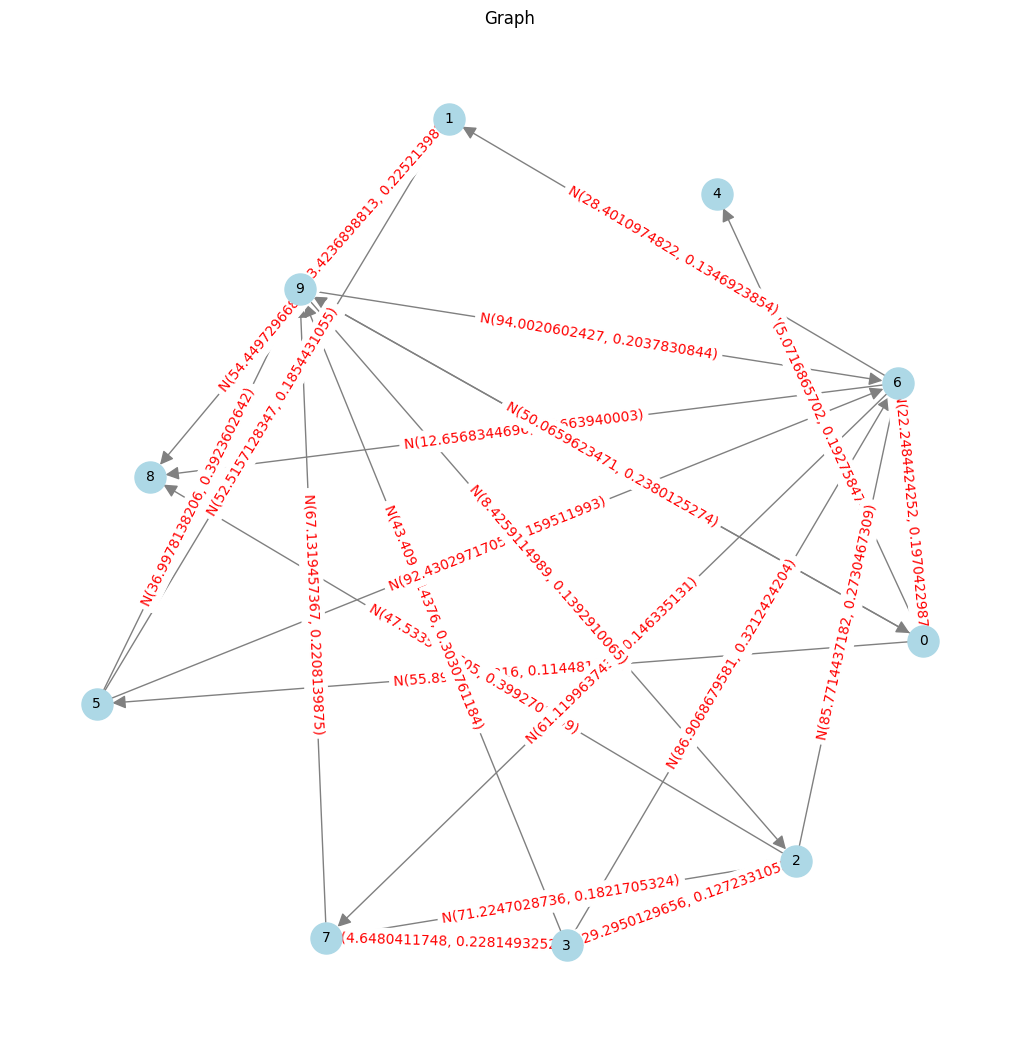

In [12]:
# Create an istance of the class
g1 = DRWG()

# Plot the model
g1.plot()

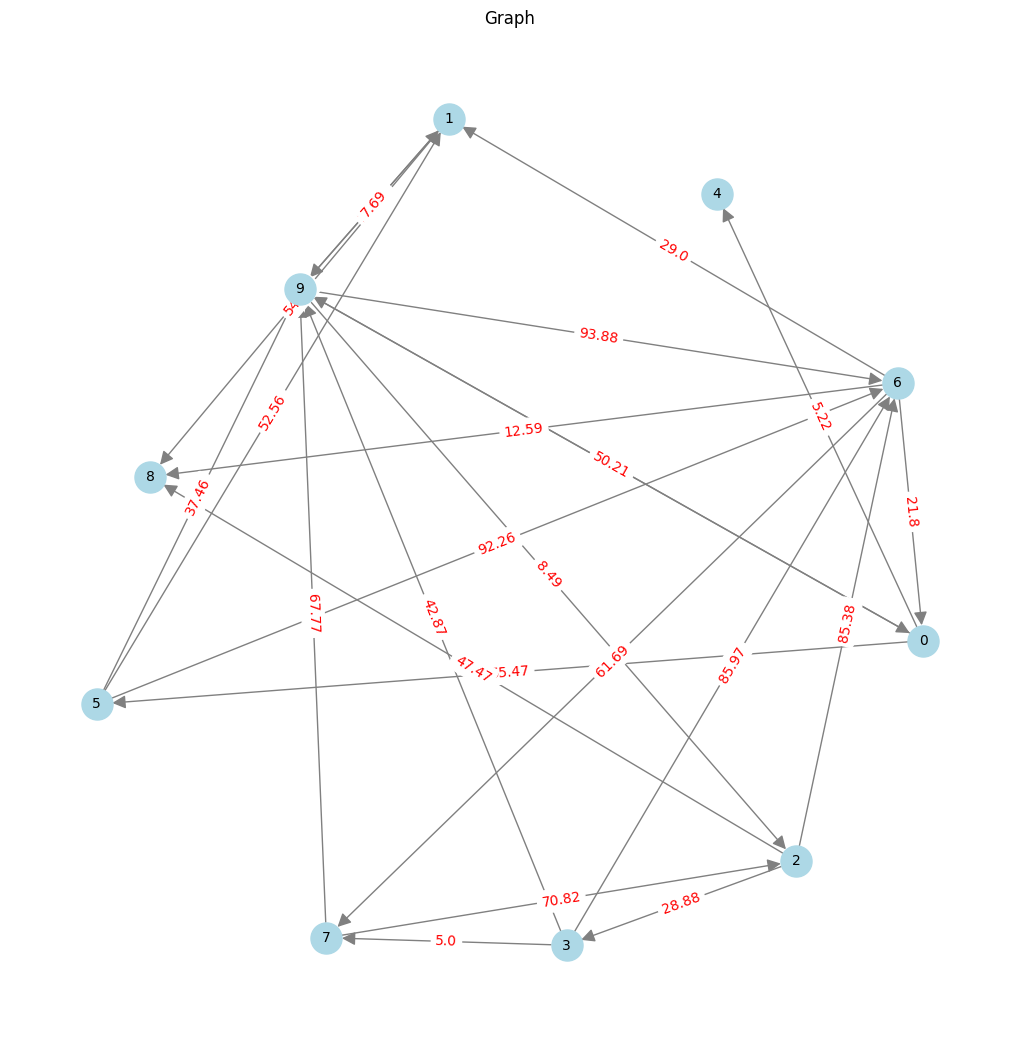

In [9]:
# Sample from the model
sample = g1.sample()

# Plot the sample
g1.plot_graph(sample)

## Max Formulation

### Gumbel distribution
The Gumbel distribution is often used to model the distribution of the maximum (or the minimum) of a set of r.v.

In [11]:
class GUMB:
    def __init__(self, rws : list[RandomWeight]):
        self.random_weights = rws
        # self.mu = max(rw.mean for rw in self.random_weights)
        # self.beta = sqrt(sum(rw.variance for rw in self.random_weights))
        
        # self.mu = max(rw.mean for rw in self.random_weights) + max(rw.standard_deviation for rw in self.random_weights) * math.sqrt(2 * math.log(len(self.random_weights)))
        # self.beta = max(rw.standard_deviation for rw in self.random_weights) / (math.sqrt(2 * math.log(len(self.random_weights))))
           
           
        # edo paper   
        sigma_bar = 1/sqrt(len(self.random_weights)) * sqrt(sum(rw.variance for rw in self.random_weights))
        h_0 = np.log(-np.log(1/np.e))
              
        self.mu = np.mean([rw.mean for rw in self.random_weights]) + sigma_bar * h_0
        
        # self.beta = sigma_bar * np.log(len(self.random_weights ))
        # self.beta = sigma_bar * 1
        # self.beta = sqrt(np.mean([rw.variance for rw in self.random_weights])) * np.log(len(self.random_weights))
        # self.alpha = np.mean([rw.mean for rw in self.random_weights])    
        
        self.expectation = self.mu + np.euler_gamma * self.beta

In [12]:
mx = GUMB([RandomWeight(np.random.uniform(3,5), np.random.uniform(0.1,0.4)) for i in range(20000)])

print(f"Expectation: {mx.expectation}")

AttributeError: 'GUMB' object has no attribute 'beta'

### Exact distribution
Even if the Gumbel distribution is used in some models, it is an approximation.
We will study how well it approximate w.r.t. the true distribution

In [23]:
class MAX:
    def __init__(self, rws : list[RandomWeight]):
        self.random_weights = rws

    def cdf(self, x):
        return prod(rw.cdf(x) for rw in self.random_weights)

    def pdf(self, x):
        return self.cdf(x) * sum((rw.pdf(x) / (rw.cdf(x) + 1e-17))  for rw in self.random_weights)

    def get_expectation(self, lb = -np.inf, ub = np.inf):
        return quad(lambda x: x * self.pdf(x), a = lb, b = ub)
    

class BoostMAX(MAX):
    def __init__(self, rws : list[RandomWeight], threshold_for_single_cdf : float = 0.003, upper_bound_precision: float = 5.0, same_distribution = False):
        super().__init__(rws)
        self.same_distribution = same_distribution
        self.lower_bound = self.calculate_lower_bound(threshold_for_single_cdf)
        self.upper_bound = self.calculate_upper_bound(upper_bound_precision)
    
    def calculate_lower_bound(self, threshold_for_single_cdf): 
        if self.same_distribution:
            return max(stats.norm.ppf(math.exp(math.log(threshold_for_single_cdf)/len(self.random_weights)), loc=v.mean, scale=v.standard_deviation) for v in self.random_weights)
        else:       
            return max(stats.norm.ppf(threshold_for_single_cdf, loc=rw.mean, scale=rw.standard_deviation) for rw in self.random_weights)
    
    def calculate_upper_bound(self, upper_bound_precision):
        return max(rw.mean + upper_bound_precision * rw.standard_deviation for rw in self.random_weights)
    
    def get_expectation(self):
        return super().get_expectation(lb=self.lower_bound, ub=self.upper_bound)

In [ ]:
random_v = [RandomWeight(np.random.uniform(1,4), np.random.uniform(0.1,0.4)) for i in range(10)]
for i in random_v:
    print(i)

m = MAX(random_v)
m.get_expectation()

N(2.93, 0.02)
N(1.62, 0.04)
N(2.83, 0.04)
N(3.12, 0.13)
N(2.54, 0.03)
N(3.05, 0.15)
N(3.06, 0.07)
N(2.58, 0.02)
N(3.96, 0.14)
N(1.06, 0.15)


(3.978707530790754, 1.4131076677042825e-08)

### Comparison

In [15]:
start = 100
max_variables = 10000
step = 300

exact_results = []
exact_computing_time = []

approximation_results = []
approximation_computing_time = []

n_variables = range(start, max_variables, step)

for n_variable in n_variables:
    print("N-Variables: ", n_variable)
    
    random_vars = [RandomWeight(np.random.uniform(1,4), np.random.uniform(0.1,0.4)) for i in range(n_variable)]
    
    start_time = time.time()
    mx = BoostMAX(random_vars)
    result, error = mx.get_expectation()
    exact_results.append(result)
    exact_computing_time.append(time.time() - start_time)
    
    start_time = time.time()
    mx = GUMB(random_vars)
    approximation_results.append(mx.expectation)
    approximation_computing_time.append(time.time() - start_time)



fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# exact_results e approximation_results
axes[0].plot(n_variables, exact_results, label='Exact Results', color='blue', marker='o')
axes[0].plot(n_variables, approximation_results, label='Approximation Results', color='orange', marker='s')
axes[0].set_title('Results Comparison')
axes[0].set_xlabel('Number of Variables')
axes[0].set_ylabel('Results')
axes[0].legend()
axes[0].grid(True)

# exact_computing_time e approximation_computing_time
axes[1].plot(n_variables, exact_computing_time, label='Exact Computing Time', color='green', marker='o')
axes[1].plot(n_variables, approximation_computing_time, label='Approximation Computing Time', color='red', marker='s')
axes[1].set_title('Computing Time Comparison')
axes[1].set_xlabel('Number of Variables')
axes[1].set_ylabel('Computing Time (s)')
axes[1].legend()
axes[1].grid(True)
# print
plt.tight_layout()
plt.show()
    

N-Variables:  100
N-Variables:  400


KeyboardInterrupt: 

## Distance estimation
In this section an algorithm to estimate distances among nodes will be developed. This estimation can be interpreted as a static analisis of the graph. It can be than exploited to perform a dinamic algorithm when an instance is available.

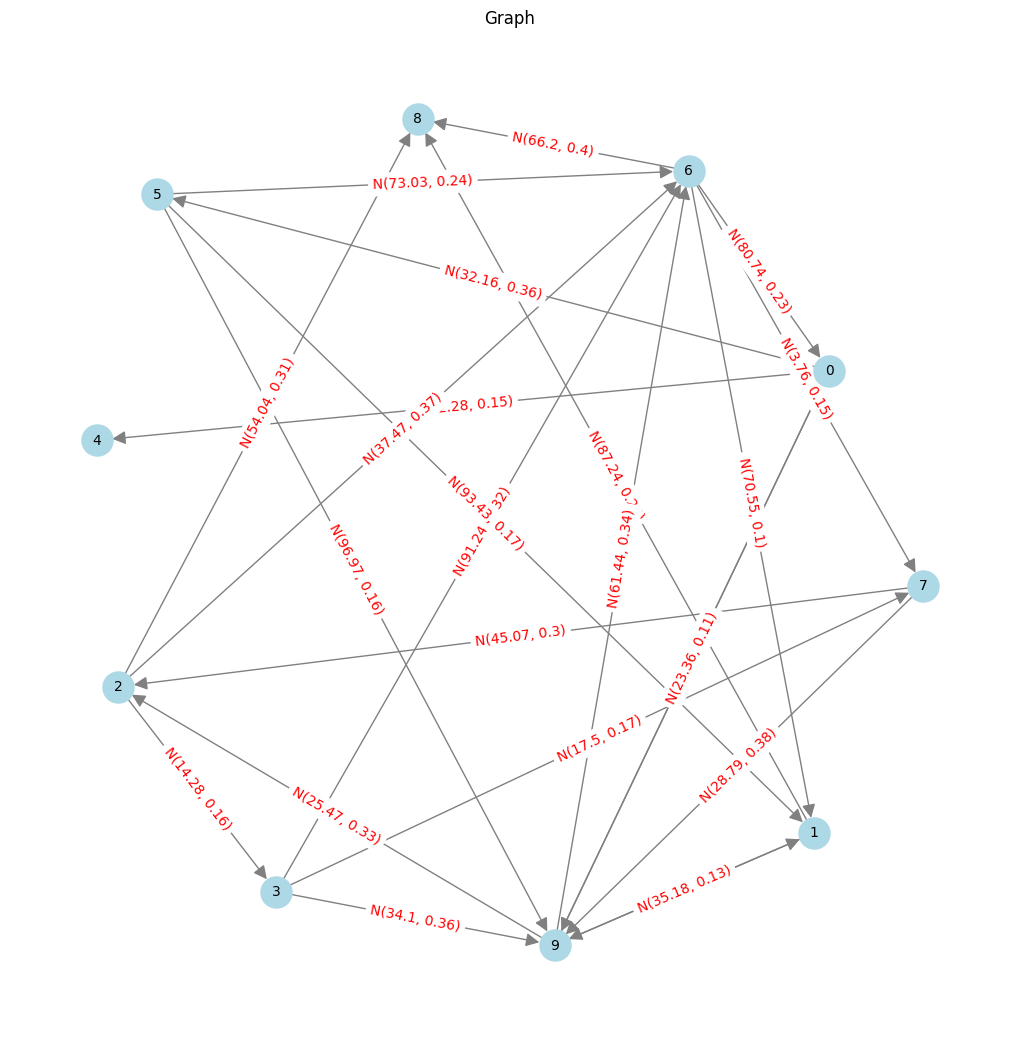

In [16]:
# Create an istance of the class
G = DRWG()

# Plot the model
G.plot()

In [29]:
G = DRWG(n=15)
G.floyd_warshall()

cell_width = 16

print("Vertices".ljust(cell_width), end = "")
for v in range(G.n):
    print(f"{v}".ljust(cell_width), end = "")
print()

for s in range(G.n):
    print(f"{s}".ljust(cell_width), end = "")
    for v in range(G.n):
        value = G._distance_estimate[s][v]._estimate
        print(f"{value}".ljust(cell_width), end = "")
    print()
print()


Vertices        0               1               2               3               4               5               6               7               8               9               10              11              12              13              14              
0               None            N(77.85, 0.77)  N(69.91, 0.52)  N(73.3, 1.09)   N(8.26, 0.12)   N(68.58, 0.12)  N(79.22, 0.92)  N(132.57, 1.46) N(62.29, 0.95)  N(58.92, 0.81)  N(57.74, 0.48)  N(120.24, 0.72) N(87.03, 0.19)  N(81.43, 0.85)  N(50.67, 0.48)  
1               N(86.3, 0.25)   None            N(54.97, 1.09)  N(52.29, 0.63)  N(69.66, 0.83)  N(53.64, 0.7)   N(58.21, 0.46)  N(111.56, 1.0)  N(41.28, 0.49)  N(37.91, 0.35)  N(119.14, 1.19) N(101.24, 0.59) N(147.24, 1.35) N(109.68, 0.54) N(83.61, 0.17)  
2               N(38.63, 0.16)  N(7.95, 0.25)   None            N(31.92, 0.29)  N(46.89, 0.27)  N(61.59, 0.95)  N(66.16, 0.72)  N(91.19, 0.66)  N(20.92, 0.15)  N(45.86, 0.6)   N(96.37, 0.63)  N(109.19, 0.84) N(125.66, 0.34) N(115

In [19]:
G = DRWG(15)
#G.plot()

In [20]:
sample = G.sample()
#G.plot_graph(sample)

In [21]:
G.floyd_warshall()

In [12]:
[n for n in G.graph.successors(0)]
print(not [])
print([False] * G.n)

True
[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]


In [22]:
tup = ()
length = 0

for u in range(G.n):
    for v in range(G.n):
        temp = nx.shortest_path_length(sample, u, v, weight="random_weight")
        if(temp > length):
            length = temp
            tup = (u, v)

print(tup)
print(length)

(11, 10)
164.65136462119446


In [23]:
# GREEDY 
s = 11
t = 10

if(s==t):
    print("Source==Terminal")
    exit(0)

if G._distance_estimate[s][t]._estimate == None:
    print("No path available")
    exit(-404)

current_node = s
path = [current_node]

visited = [False] * G.n

while(current_node != t):
    neighbours = [n for n in sample.successors(current_node)]
    if not neighbours:
        print("No path available")
        break
    
    neighbour_to_esaminate = []
    for neighbour in neighbours:
        estimate = G._distance_estimate[neighbour][t]._estimate
        print(visited[neighbour])
        print(estimate is not None)
        if visited[neighbour] == False and (neighbour == t or estimate is not None):
            print(current_node, neighbour, sample.get_edge_data(u = current_node, v = neighbour))
            print(estimate)
            if(neighbour == t):
                neighbour_to_esaminate.append((neighbour, sample.get_edge_data(u = current_node, v = neighbour)["random_weight"]))
            else:
                neighbour_to_esaminate.append((neighbour, sample.get_edge_data(u = current_node, v = neighbour)["random_weight"] + estimate.mean))
            
    if not neighbour_to_esaminate:
        print("No path available")
        break
    
    index = np.argmin([neighbour[1] for neighbour in neighbour_to_esaminate])
    
    current_node = neighbour_to_esaminate[index][0]
    visited[current_node] = True
    path.append(current_node)

cost = 0
print(path)

current_node = s
for next in path:
    if(next != s):
        cost += sample.get_edge_data(u = current_node, v = next)["random_weight"]
        current_node = next

print("cost: ", cost)

path = nx.shortest_path(sample, s, t, weight="random_weight")
print(path)

cost = 0
current_node = s
for next in path:
    if(next != s):
        cost += sample.get_edge_data(u = current_node, v = next)["random_weight"]
        current_node = next

print("cost: ", cost)


False
True
11 0 {'label': 61.39, 'random_weight': 61.3919926906161}
N(109.24, 0.51)
False
True
11 8 {'label': 41.01, 'random_weight': 41.01343593778813}
N(123.33, 0.68)
False
True
8 13 {'label': 52.91, 'random_weight': 52.91442488460913}
N(70.49, 0.53)
False
True
8 1 {'label': 92.03, 'random_weight': 92.0277359103949}
N(108.89, 0.85)
False
True
8 3 {'label': 29.3, 'random_weight': 29.302395313583094}
N(154.38, 0.92)
False
True
13 1 {'label': 82.67, 'random_weight': 82.66721410658361}
N(108.89, 0.85)
False
True
13 3 {'label': 3.01, 'random_weight': 3.0058733039860446}
N(154.38, 0.92)
False
True
13 4 {'label': 44.35, 'random_weight': 44.3508004133663}
N(26.54, 0.16)
False
True
13 5 {'label': 42.79, 'random_weight': 42.788298096309404}
N(107.05, 0.28)
False
True
13 7 {'label': 95.56, 'random_weight': 95.56129319854239}
N(137.17, 0.91)
False
True
13 9 {'label': 4.56, 'random_weight': 4.561014917755851}
N(95.59, 0.66)
False
True
13 11 {'label': 47.96, 'random_weight': 47.95936238787049}
N(1

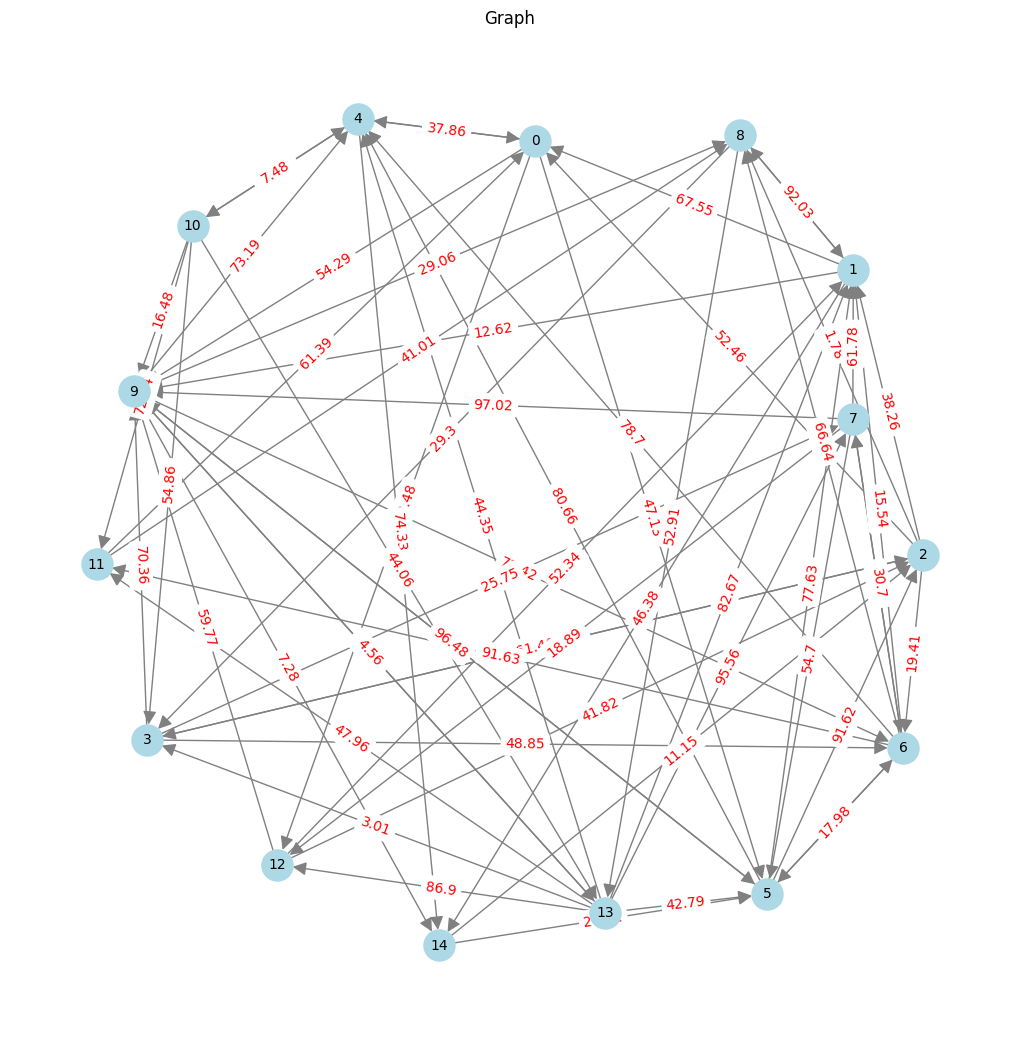

In [24]:
G.plot_graph(sample)

In [25]:

def plot_with_shortest_path(self, shortest_path):

        node_colors = [self._SHORTEST_PATH_NODE_COLOR if node in shortest_path else self._NODE_COLOR for node in self.graph.nodes()]
        edge_colors = [self._SHORTEST_PATH_EDGE_COLOR if (u in shortest_path and v in shortest_path and (u, v) in zip(shortest_path[:-1], shortest_path[1:])) else self._EDGE_COLOR
                       for u, v in self.graph.edges()]

        self.plot_graph(sample, node_color = node_colors, edge_color = edge_colors)

plot_with_shortest_path(G, path)

AttributeError: 'DRWG' object has no attribute '_SHORTEST_PATH_NODE_COLOR'

In [90]:
print([u for u in G.in_edges(0)])
print([u for u, _ in G.in_edges(0)])

print(G.has_edge(2, 6))
print(G.has_edge(6, 2))

print(G.graph.get_edge_data(2, 6)["random_weight"])


[(6, 0), (9, 0)]
[6, 9]
True
False
N(48.51, 0.23)


In [103]:
print(None * 2)

TypeError: unsupported operand type(s) for *: 'NoneType' and 'int'

In [72]:
#print(G.estimate_distances())
print(G.in_edges(0))

for i in range(G.n):
    for j in range(G.n):
        if not G.has_path(i, j):
            print("Non esiste un cammino da ", i," a ", j, ".")

if nx.is_strongly_connected(G.graph):
    print("connesso")
else:
    print("non connesso")

[(6, 0), (9, 0)]
Non esiste un cammino da  4  a  0 .
Non esiste un cammino da  4  a  1 .
Non esiste un cammino da  4  a  2 .
Non esiste un cammino da  4  a  3 .
Non esiste un cammino da  4  a  5 .
Non esiste un cammino da  4  a  6 .
Non esiste un cammino da  4  a  7 .
Non esiste un cammino da  4  a  8 .
Non esiste un cammino da  4  a  9 .
Non esiste un cammino da  8  a  0 .
Non esiste un cammino da  8  a  1 .
Non esiste un cammino da  8  a  2 .
Non esiste un cammino da  8  a  3 .
Non esiste un cammino da  8  a  4 .
Non esiste un cammino da  8  a  5 .
Non esiste un cammino da  8  a  6 .
Non esiste un cammino da  8  a  7 .
Non esiste un cammino da  8  a  9 .
non connesso


## Marco and Edos doing things

In [11]:
nodes = 10 # nodi del grafo da cui calcolare le distanze
distance_prediction_table = [[RandomWeight(1,0.2)] * nodes] * nodes 

# calcola tabella totale
# TODO
distance_prediction_table

[[<__main__.RandomWeight at 0x1cfe81c6bb0>,

# Brutta

In [38]:
import matplotlib.pyplot as plt


random_vars = [RandomWeight(np.random.uniform(10,20), np.random.uniform(0.1,0.4)) for i in range(20)]
maa = MAX(random_vars)
maax = BoostMAX(random_vars, 0.003, 5)

# Plot the function over the finite range
x_vals = np.linspace(-30, 30, 1000)
y_vals = [ maa.pdf(x) for x in x_vals]

print(maa.get_expectation())
print(maax.get_expectation())

plt.plot(x_vals, y_vals)
plt.title("FUNZIONE DA INTEGRARE")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.grid()
plt.show()

ValueError: Infinity inputs cannot be used with break points.

## TEST

In [36]:
random_vars = [RandomWeight(np.random.uniform(3,5), np.random.uniform(0.1,0.4)) for i in range(500)]
m = MAX(random_vars)
m_boost = BoostMAX(random_vars, threshold_for_single_cdf=0.03, upper_bound_precision=5)

start = time.time()
print(m.get_expectation())
print("Finito in ", time.time() - start)

start = time.time()
print(m_boost.get_expectation())
print("Finito in ", time.time() - start)

TypeError: super() argument 1 must be type, not BoostMAX

## Random Weighted Degree

In un sample,

$ d_w^+(u) = \sum_{v \in \mathcal{N}(u)} w(u, v) $  
$ d_w^-(u) = \sum_{v \in \mathcal{N}(u)} w(v, u) $

dato che $ W(u, v) \sim \mathcal{N}(\mu_{(u, v)}, \sigma^2_{(u, v)}) $  
$ d_W^-(u) = \sum_{v \in \mathcal{N}(u)} W(v, u) \sim \mathcal{N}(\sum_{v \in \mathcal{N}(u)} \mu_{(v, u)}, \sigma^2_{(v, u)})$  

$P_r(d_W^-(u)\leq 5) = \Phi(5) $

$P_r(1 \leq d_W^-(u)\leq 5) = \Phi(5) -  \Phi(1)$

$d^+_w(G) = max(d_w^+(u))$

In [10]:
def sample_degree(n_samples):
  d_in_total = {}
  d_out_total = {}
  for v in g1.graph.nodes():
    d_in_total.update({v: 0})
    d_out_total.update({v: 0})


  for i in range(int(n_samples)):
    sample = g1.sample()
    in_degrees = sample.in_degree(weight='random_weight')
    out_degrees = sample.out_degree(weight='random_weight')
    for v in g1.graph.nodes():
      d_in_total[v] += in_degrees[v]
      d_out_total[v] += out_degrees[v] 

  for v in d_in_total:
    d_in_total[v] = d_in_total[v] / n_samples
    d_out_total[v] = d_out_total[v] / n_samples
    
  return (d_in_total, d_out_total)


In [11]:
sample_degree(100000)

({0: 72.31819949122557,
  1: 104.33976352381711,
  2: 79.65052037667438,
  3: 29.294984983613716,
  4: 5.071258165489683,
  5: 55.89177154715483,
  6: 359.1083775791414,
  7: 65.76497223823313,
  8: 114.6410545512698,
  9: 221.3650985327748},
 {0: 127.26615941693207,
  1: 61.97640502462497,
  2: 162.5984649556256,
  3: 134.96106271304797,
  4: 0.0,
  5: 181.93872337410727,
  6: 124.42952357546139,
  7: 138.35554859019982,
  8: 0.0,
  9: 175.92011333939058})

N_SAMPLE -> 2
N_SAMPLE -> 1113
N_SAMPLE -> 2224
N_SAMPLE -> 3335
N_SAMPLE -> 4446
N_SAMPLE -> 5557
N_SAMPLE -> 6668
N_SAMPLE -> 7779
N_SAMPLE -> 8890
N_SAMPLE -> 10001


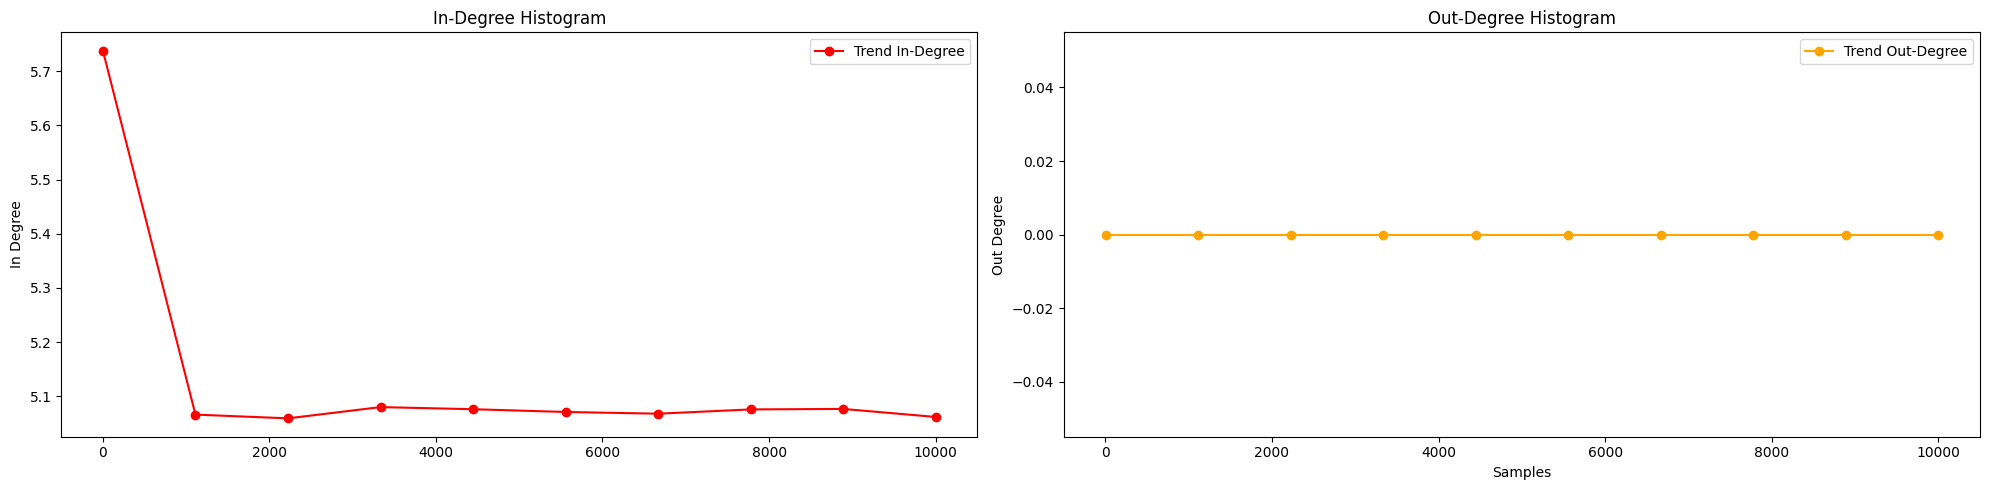

In [12]:
analyzed_node = 4

min_iterations = 1
max_iterations = 10000
step = 10

in_degree_list = []
out_degree_list = []

iterations = [1] + np.linspace(min_iterations, max_iterations, num=step)
for k_iterations in iterations:
    print("N_SAMPLE ->", int(k_iterations))
    in_degrees, out_degrees = sample_degree(k_iterations)
    in_degree_list.append(in_degrees[analyzed_node])
    out_degree_list.append(out_degrees[analyzed_node])


# - Aggiungi linea di media teorica
fig, axs = plt.subplots(1, 2, figsize=(20, 5), sharex=True)
#axs[0].bar(iterations, in_degree_list, color='blue', alpha=0.7, label='In-Degree')
axs[0].plot(iterations, in_degree_list, color='red', marker='o', label='Trend In-Degree')
axs[0].set_title('In-Degree Histogram')
axs[0].set_ylabel('In Degree')
axs[0].legend()

#axs[1].bar(iterations, out_degree_list, color='green', alpha=0.7, label='Out-Degree')
axs[1].plot(iterations, out_degree_list, color='orange', marker='o', label='Trend Out-Degree')
axs[1].set_title('Out-Degree Histogram')
axs[1].set_xlabel('Samples')
axs[1].set_ylabel('Out Degree')
axs[1].legend()

plt.tight_layout()
plt.show()

In [13]:
# - Iterazioni che dipendono da formula di parpa ma in generale anche da grado non pesato e varianza totale

in_edges = g1.graph.in_edges(analyzed_node, data=True)

mean = sum(edge[2]['random_weight'].mean for edge in in_edges) 
std_dev = sqrt(sum(edge[2]['random_weight'].standard_deviation**2 for edge in in_edges))

margin_error = 0.05
confidence_value = 1.96

K_NEEDED = ceil(((confidence_value * std_dev) / margin_error)**2)
print(K_NEEDED)
sample_degree(K_NEEDED)

297


({0: 72.3537492972148,
  1: 104.40572735297333,
  2: 79.65832262703732,
  3: 29.310111665257747,
  4: 5.088510967237381,
  5: 55.90518715671911,
  6: 359.099281856005,
  7: 65.82489958668704,
  8: 114.69858805986303,
  9: 221.34756958103057},
 {0: 127.24351987913167,
  1: 61.97762889129781,
  2: 162.65623656743128,
  3: 135.05142704868547,
  4: 0.0,
  5: 182.01800312542045,
  6: 124.46107498186744,
  7: 138.3476995757772,
  8: 0.0,
  9: 175.93635808041384})

In [14]:
in_degrees = []
 
for v in g1.graph.nodes():
    in_edges = g1.graph.in_edges(v, data=True)
    mean = sum(edge[2]['random_weight'].mean for edge in in_edges) 
    std_dev = sqrt(sum(edge[2]['random_weight'].standard_deviation**2 for edge in in_edges))
    rw = RandomWeight(mean=mean, standard_deviation=std_dev)
    in_degrees.append(rw)
    
get_expectation_gumbel(in_degrees)

NameError: name 'get_expectation_gumbel' is not defined

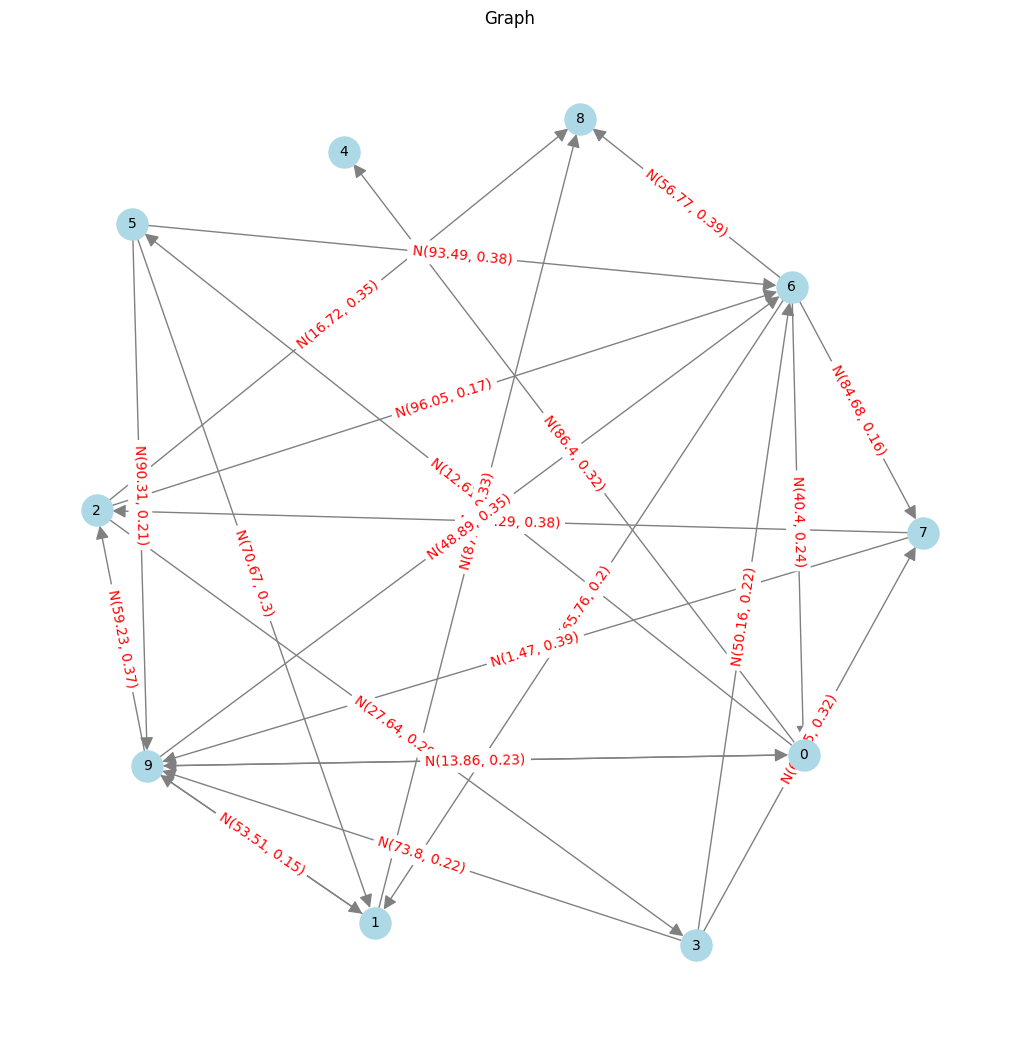

In [ ]:
g1 = DRWG()
g1.plot()

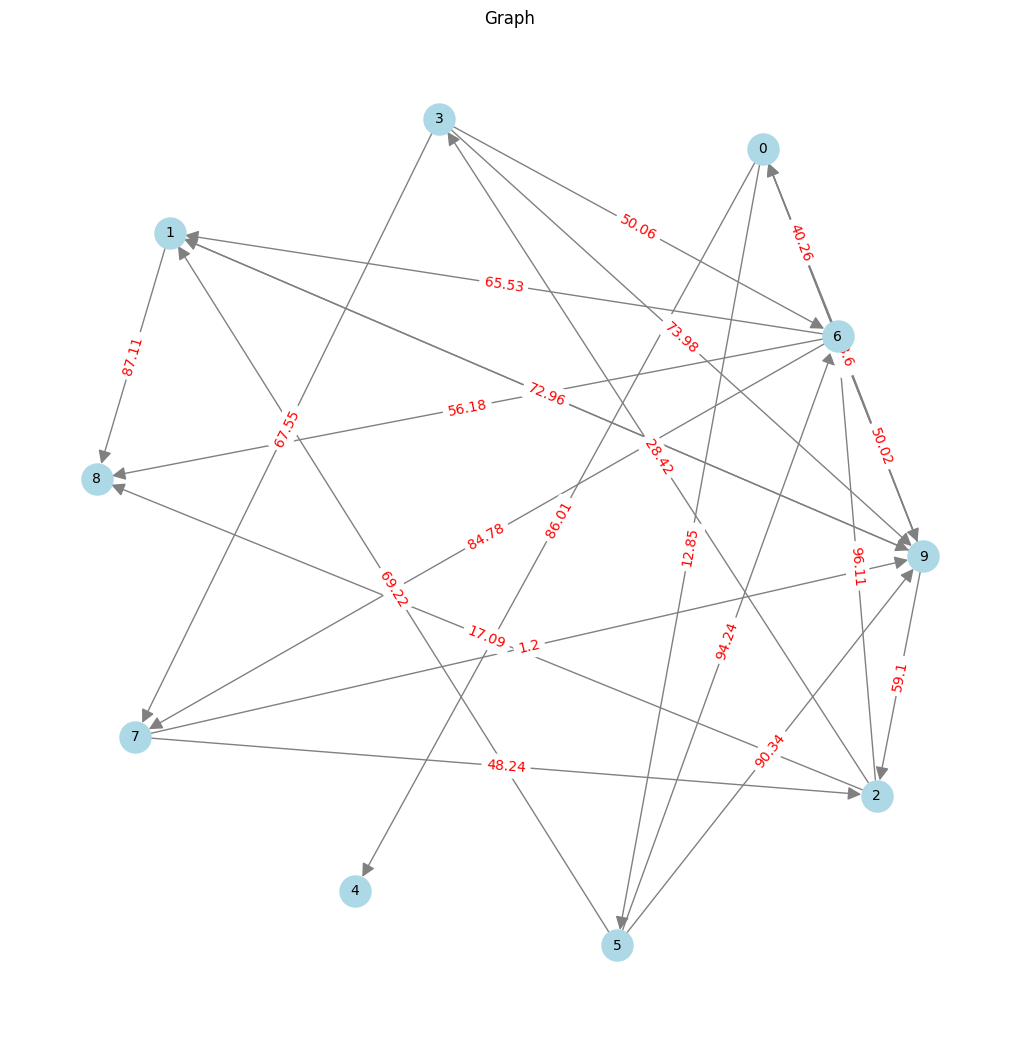

In [ ]:
g1.plot_graph(g1.sample())

In [ ]:
# TODO:
# Stampare grafico distribuzione di gumbel 
# e il Fm(m) (produttoria) della formula
# per fare la verifica
# (cross-entropy per la similarità)

Uploading and generating the graph with real data downloaded from Binance.


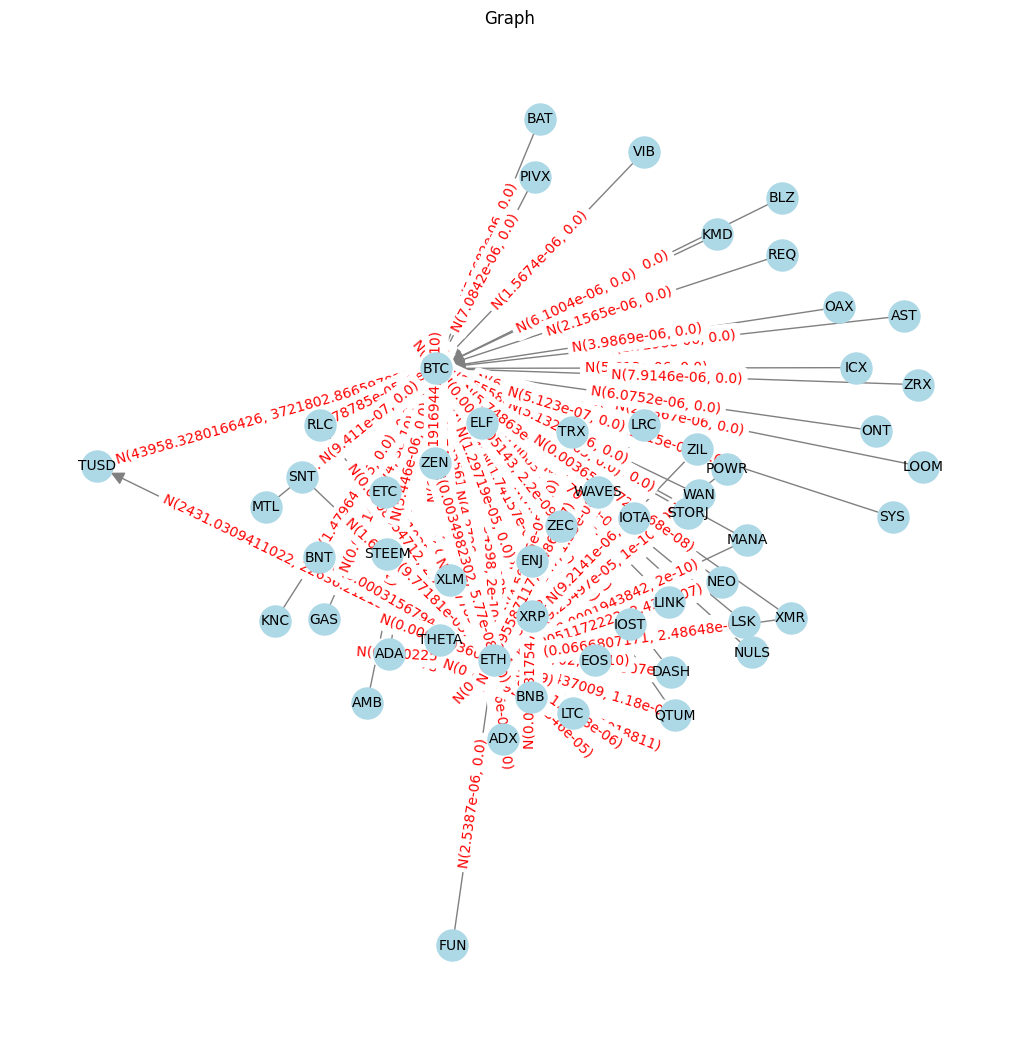

Number of vertices: 55
Number of arcs: 91


In [13]:
# Reading the graph from the XML file
crypto_graph = DRWG()
file_path = "crypto_graph.graphml"
crypto_graph.generate_graph_from_file(file_path)
crypto_graph.plot_graph(crypto_graph.graph)

print(f"Number of vertices: {crypto_graph.graph.number_of_nodes()}")
print(f"Number of arcs: {crypto_graph.graph.number_of_edges()}")